In [53]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe_connected"
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point


#### EDA

In [27]:
dataset = pd.read_csv('uber-raw-data-apr14.csv')
dataset.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [28]:
dataset.shape

(564516, 4)

Ce dataset compte 564516 lignes

In [29]:
dataset.dtypes

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

In [30]:
dataset.describe(include='all')

,Date/Time,Lat,Lon,Base
count,564516,564516.000000,564516.000000,564516
unique,41999,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02682
freq,97,NaN,NaN,227808
mean,NaN,40.740005,-73.976817,NaN
std,NaN,0.036083,0.050426,NaN
min,NaN,40.072900,-74.773300,NaN
25%,NaN,40.722500,-73.997700,NaN
50%,NaN,40.742500,-73.984800,NaN
75%,NaN,40.760700,-73.970000,NaN


In [31]:
100 *dataset.isnull().sum() / dataset.shape[0]

Date/Time    0.0
Lat          0.0
Lon          0.0
Base         0.0
dtype: float64

Il n'y a pas de valeurs manquantes dans ce dataset

N'ayant pas de connaissance sur la colonne "Base" et n'étant pas certain de son utilité, on décide de l'écarter. 

In [32]:
dataset.drop("Base", axis=1, inplace=True)
dataset.head()

,Date/Time,Lat,Lon
0,4/1/2014 0:11:00,40.7690,-73.9549
1,4/1/2014 0:17:00,40.7267,-74.0345
2,4/1/2014 0:21:00,40.7316,-73.9873
3,4/1/2014 0:28:00,40.7588,-73.9776
4,4/1/2014 0:33:00,40.7594,-73.9722


Dans son état actuelle (type Object), la colonne "Date" n'est pas exploitable. On décide de la convertir en type date.

In [33]:
dataset["Date/Time"] = pd.to_datetime(dataset["Date/Time"])
dataset.head()

,Date/Time,Lat,Lon
0,2014-04-01 00:11:00,40.7690,-73.9549
1,2014-04-01 00:17:00,40.7267,-74.0345
2,2014-04-01 00:21:00,40.7316,-73.9873
3,2014-04-01 00:28:00,40.7588,-73.9776
4,2014-04-01 00:33:00,40.7594,-73.9722


In [34]:

dataset["DayOfWeek"] = dataset["Date/Time"].dt.day_name()
dataset.head()

,Date/Time,Lat,Lon,DayOfWeek
0,2014-04-01 00:11:00,40.7690,-73.9549,Tuesday
1,2014-04-01 00:17:00,40.7267,-74.0345,Tuesday
2,2014-04-01 00:21:00,40.7316,-73.9873,Tuesday
3,2014-04-01 00:28:00,40.7588,-73.9776,Tuesday
4,2014-04-01 00:33:00,40.7594,-73.9722,Tuesday


In [35]:
dataset_grouped = dataset.groupby('DayOfWeek').size().reset_index(name='Total')

# Affichage du nouveau DataFrame
print(dataset_grouped)

   DayOfWeek   Total
0     Friday   90303
1     Monday   60861
2   Saturday   77218
3     Sunday   51251
4   Thursday   85067
5    Tuesday   91185
6  Wednesday  108631


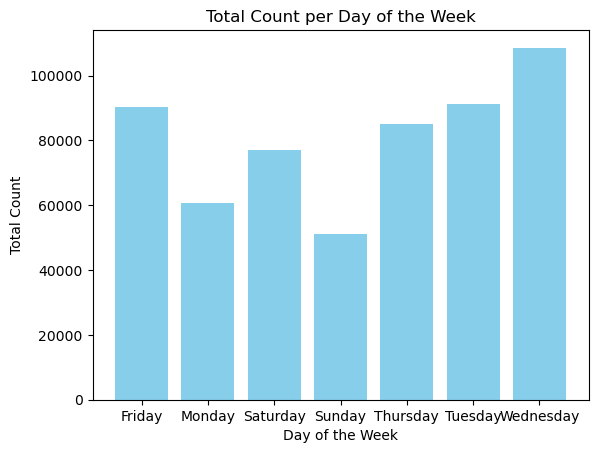

In [36]:
plt.bar(dataset_grouped["DayOfWeek"], dataset_grouped["Total"], color="skyblue")
plt.xlabel('Day of the Week')
plt.ylabel('Total Count')
plt.title('Total Count per Day of the Week')

plt.show()

On observe que le nombre de prises en charge n'est pas homogène dans la semaine et varie en fonction du jour. Les jours les plus chargés sont : 
- mercredi
- mardi 
- vendredi

Regardons plus en détail les prises en charge horaires pour la journée de mercredi par exemple

C:\Users\Dominique Ourmiah\AppData\Local\Temp\ipykernel_27756\985728856.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



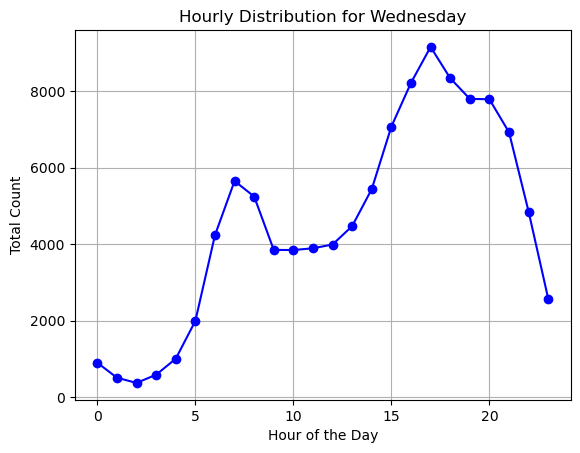

In [37]:
# Filtrer les données pour une journée spécifique, par exemple le "mercredi"
ds_friday = dataset[dataset['DayOfWeek'] == 'Wednesday']

# Extraire l'heure de la colonne "Date/Time"
ds_friday['Hour'] = ds_friday['Date/Time'].dt.hour

# Grouper les données par heure et compter le nombre d'occurrences
hourly_data = ds_friday.groupby('Hour').size()

# Tracé du graphique
plt.plot(hourly_data.index, hourly_data.values, marker='o', linestyle='-', color='b')

# Ajout d'étiquettes et d'un titre
plt.xlabel('Hour of the Day')
plt.ylabel('Total Count')
plt.title('Hourly Distribution for Wednesday')

# Affichage de la grille pour une meilleure lisibilité
plt.grid(True)

# Affichage du graphique
plt.show()

On observe que les prises en charge varie durant la journée.

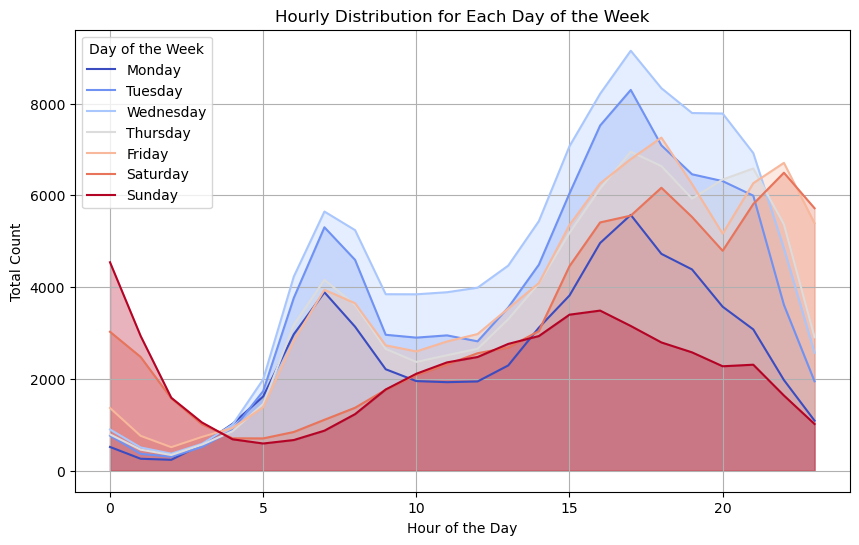

In [38]:
dataset['Hour'] = dataset['Date/Time'].dt.hour

# Liste des jours de la semaine dans l'ordre
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Initialisation de la figure
plt.figure(figsize=(10, 6))

# Générer un dégradé de couleurs du blanc au bleu
colors = [plt.cm.coolwarm(i) for i in np.linspace(0, 1, len(days_of_week))]

# Tracé des courbes et remplissage pour chaque jour de la semaine sans les points
for day, color in zip(days_of_week, colors):
    # Filtrer les données pour un jour spécifique
    df_day = dataset[dataset['DayOfWeek'] == day]
    
    # Grouper les données par heure et compter le nombre d'occurrences
    hourly_data = df_day.groupby('Hour').size()
    
    # Tracé de la courbe sans les points (pas de marker)
    plt.plot(hourly_data.index, hourly_data.values, linestyle='-', label=day, color=color)
    
    # Remplissage de la zone sous la courbe avec le dégradé
    plt.fill_between(hourly_data.index, hourly_data.values, color=color, alpha=0.3)

# Ajout d'étiquettes et d'un titre
plt.xlabel('Hour of the Day')
plt.ylabel('Total Count')
plt.title('Hourly Distribution for Each Day of the Week')

# Affichage de la légende
plt.legend(title='Day of the Week')

# Affichage de la grille pour une meilleure lisibilité
plt.grid(True)

# Affichage du graphique
plt.show()


On constate que le nombre de prises en charge n'est pas homogène dans la semaine. La charge est fonction du jour et de l'heure.
Les jours de semaine, on observe globalement un pic de prise en charges vers 7h le matin et vers 17-18h l'après-midi, ce qui correspond aux heures de pointe des déplacements de travail, de loisirs, etc... 
Les vendredis et samedis on a un pic en fin de soirée : Cela pourrait correspondre aux déplacements de divertissements habituels du week-end (restaurants, bars, boites de nuit, etc...)
  

#### Preprocessing

Commençons notre analyese sur un extrait du dataset : 
 - Jour : Lundi
 - Heure : 7h00 

In [39]:
dataset_sample = dataset[(dataset["DayOfWeek"] == "Monday") & (dataset["Hour"] == 7)]
dataset_sample

,Date/Time,Lat,Lon,DayOfWeek,Hour
7885,2014-04-07 07:00:00,40.7848,-73.9486,Monday,7
7886,2014-04-07 07:00:00,40.7932,-73.9747,Monday,7
7887,2014-04-07 07:00:00,40.7789,-73.9558,Monday,7
7888,2014-04-07 07:01:00,40.7880,-73.9757,Monday,7
7889,2014-04-07 07:01:00,40.7213,-73.9990,Monday,7
...,...,...,...,...,...
563308,2014-04-28 07:36:00,40.7337,-73.9806,Monday,7
563309,2014-04-28 07:37:00,40.7578,-73.6402,Monday,7
563310,2014-04-28 07:41:00,40.7520,-74.0273,Monday,7
563311,2014-04-28 07:46:00,40.7513,-73.9940,Monday,7


On supprime les colonnes inutiles : Date/Time, DayOfWeek, Hour

In [40]:
columns_to_drop = ["Date/Time", "DayOfWeek", "Hour"]
dataset_sample.drop(columns=columns_to_drop, axis=1, inplace=True)
dataset_sample.head()

C:\Users\Dominique Ourmiah\AppData\Local\Temp\ipykernel_27756\3036672315.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Lat,Lon
7885,40.7848,-73.9486
7886,40.7932,-73.9747
7887,40.7789,-73.9558
7888,40.7880,-73.9757
7889,40.7213,-73.9990


In [41]:
sc = StandardScaler()
X = sc.fit_transform(dataset_sample)
print(X[0:5, :])

[[ 1.13542927  0.49727607]
 [ 1.36278439 -0.0483993 ]
 [ 0.97573936  0.34674494]
 [ 1.22204074 -0.0693064 ]
 [-0.58326719 -0.55644188]]


Nou allons maintenant construire nos clusters. Pour ce faire il nous faut au préalable déterminer le nombre optimal k de clusters. Nous commencerons par la méthode Elbow.

##### Elbow

In [42]:
wcss = []
nb_clusters = range(2, 11)
for i in nb_clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
print(wcss)

[5357.0957267385675, 3143.623757411777, 2639.521849155886, 2186.382977322533, 1697.9031490967177, 1279.5646736343356, 1112.7330367716497, 1023.8463976617222, 940.277927689407]


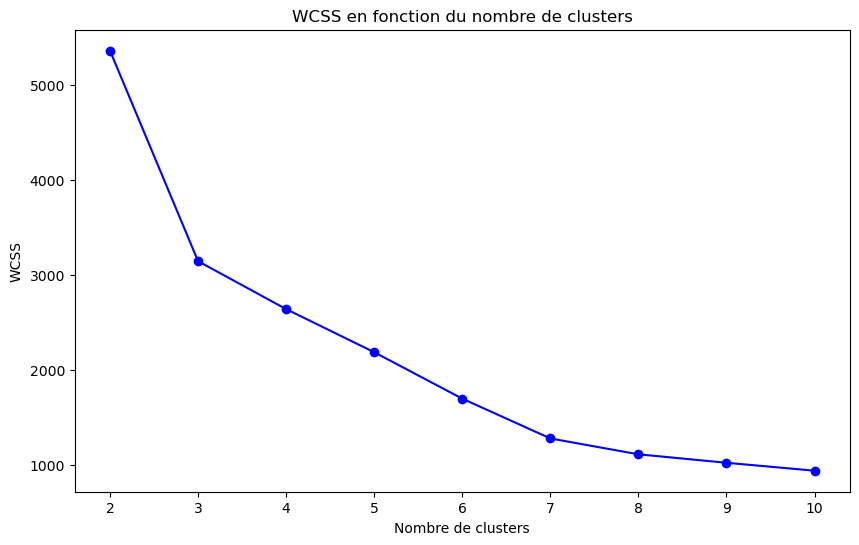

In [43]:
plt.figure(figsize=(10, 6))

plt.plot(nb_clusters, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.title('WCSS en fonction du nombre de clusters')
plt.show()

Selon ce graphe, on partirait donc sur un nombre de clusters <b>k = 6 </b>

Appliquons maintenant la méthode Silhouette

##### Silhouette

In [44]:
s_score = []
for i in nb_clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    s_score.append(silhouette_score(X, kmeans.predict(X)))
print(s_score)

[0.4226089760652633, 0.4844850387150304, 0.48195425764670335, 0.5085338505612442, 0.5263653427389223, 0.4127030251623282, 0.4109939038228795, 0.3938245347384278, 0.43505808319713485]


Text(0.5, 1.0, 'Silhouette score en fonction du nombre de clusters')

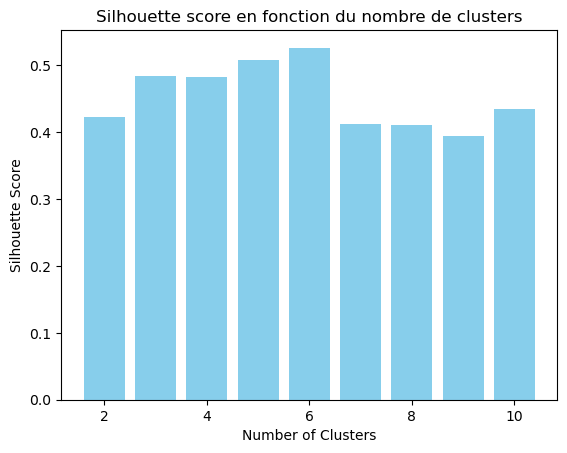

In [45]:
plt.bar(nb_clusters, s_score, color='skyblue')

# Ajout d'étiquettes et d'un titre
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score en fonction du nombre de clusters')

Même conclusion ave la méthode silhouette, le nombre optimal de clusters est <b>k = 6 </b>

##### Train

In [46]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

KMeans(n_clusters=6)

In [47]:
dataset_sample.loc[:, "Clusters"] = kmeans.predict(X)
dataset_sample.head()

C:\Users\Dominique Ourmiah\AppData\Local\Temp\ipykernel_27756\3738690004.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Lat,Lon,Clusters
7885,40.7848,-73.9486,5
7886,40.7932,-73.9747,5
7887,40.7789,-73.9558,5
7888,40.7880,-73.9757,5
7889,40.7213,-73.9990,1


##### Visualization

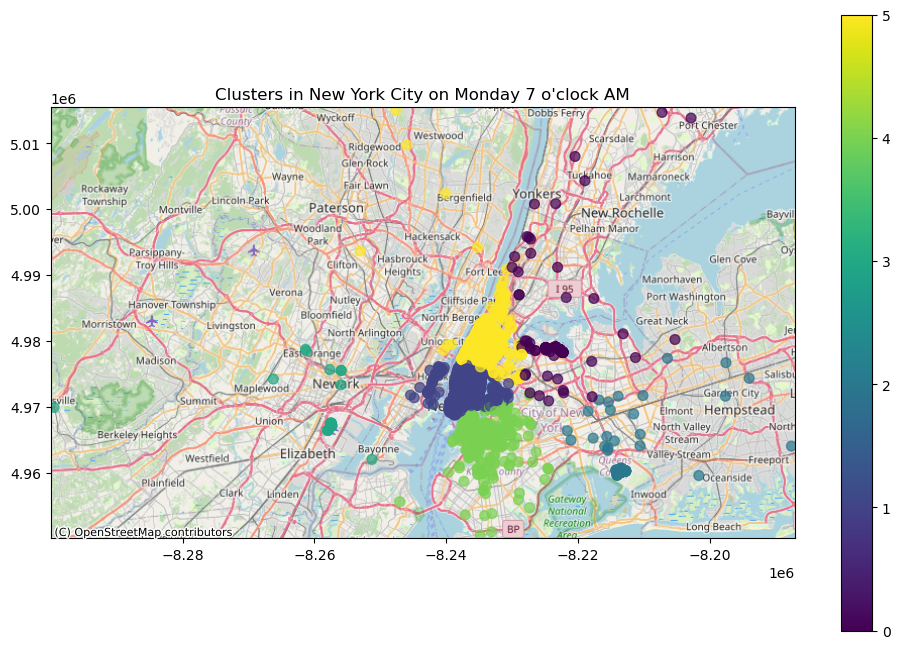

In [57]:
import contextily as ctx
from shapely.geometry import Point


# Convertir le DataFrame en GeoDataFrame
gdf = gpd.GeoDataFrame(dataset_sample, geometry=gpd.points_from_xy(dataset_sample['Lon'], dataset_sample['Lat']))

# Définir le système de coordonnées (CRS) - Web Mercator
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(12, 8))

# Tracer les points colorés par cluster
gdf.plot(ax=ax, column='Clusters', cmap='viridis', markersize=50, alpha=0.7, legend=True)

# Ajouter les tuiles de fond (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajuster les limites de la carte selon les points
ax.set_xlim(gdf.geometry.x.min() - 500, gdf.geometry.x.max() + 500)
ax.set_ylim(gdf.geometry.y.min() - 500, gdf.geometry.y.max() + 500)

# Ajouter des labels pour la ville et les quartiers principaux (si nécessaires)
ax.set_title("Clusters in New York City on Monday 7 o'clock AM")

# Afficher la carte
plt.show()

Nous allons maintenant généraliser l'analyse pour tous les jours de la semaine